
Training model with 1 conv layers and lr = 0.01
Epoch 1/15, Loss: 0.6310, Accuracy: 70.14%, Time: 4.19s
Epoch 2/15, Loss: 0.3244, Accuracy: 87.74%, Time: 4.09s
Epoch 3/15, Loss: 0.2247, Accuracy: 91.61%, Time: 4.11s
Epoch 4/15, Loss: 0.1311, Accuracy: 95.30%, Time: 4.48s
Epoch 5/15, Loss: 0.1218, Accuracy: 95.39%, Time: 4.19s
Epoch 6/15, Loss: 0.1747, Accuracy: 93.09%, Time: 4.04s
Epoch 7/15, Loss: 0.1179, Accuracy: 95.12%, Time: 4.00s
Epoch 8/15, Loss: 0.0834, Accuracy: 96.96%, Time: 4.04s
Epoch 9/15, Loss: 0.0617, Accuracy: 98.06%, Time: 4.05s
Epoch 10/15, Loss: 0.0372, Accuracy: 98.62%, Time: 4.05s
Epoch 11/15, Loss: 0.0256, Accuracy: 99.08%, Time: 4.02s
Epoch 12/15, Loss: 0.0373, Accuracy: 98.43%, Time: 4.04s
Epoch 13/15, Loss: 0.0340, Accuracy: 98.89%, Time: 4.36s
Epoch 14/15, Loss: 0.0283, Accuracy: 99.08%, Time: 4.46s
Epoch 15/15, Loss: 0.0404, Accuracy: 98.71%, Time: 4.13s

Training model with 2 conv layers and lr = 0.01
Epoch 1/15, Loss: 0.7932, Accuracy: 63.87%, Time: 3.79s


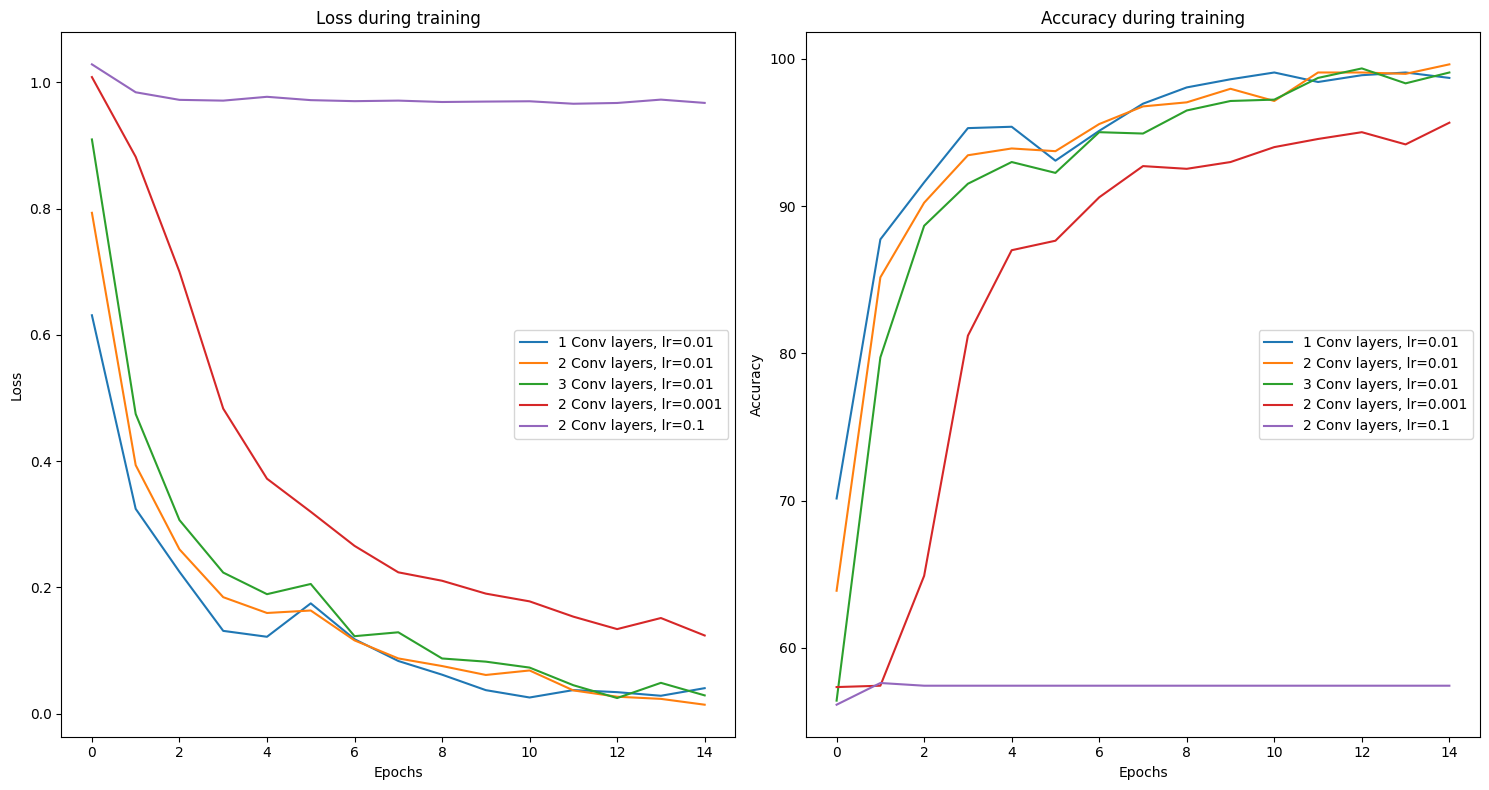

In [4]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# 数据加载与预处理
class VehicleDataset(data.Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

# 预处理步骤，包括调整图片大小和归一化
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据
def load_data(data_dir, test_size=0.2):
    labels = {'car': 0, 'bus': 1, 'truck': 2}
    img_paths = []
    img_labels = []

    # 遍历每个类别
    for label_name, label in labels.items():
        class_path = os.path.join(data_dir, label_name)
        for img_name in os.listdir(class_path):
            # 忽略隐藏文件和非图像文件
            if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(class_path, img_name)
            img_paths.append(img_path)
            img_labels.append(label)

    # 划分训练集和测试集，随机抽取20-30%的数据作为测试集
    X_train, X_test, y_train, y_test = train_test_split(img_paths, img_labels, test_size=test_size, stratify=img_labels)
    
    train_dataset = VehicleDataset(X_train, y_train, transform)
    test_dataset = VehicleDataset(X_test, y_test, transform)
    
    return train_dataset, test_dataset

# 定义改进后的卷积神经网络（支持多层卷积）
class ConvNet(nn.Module):
    def __init__(self, num_conv_layers=1, kernel_size=3, num_filters=8):
        super(ConvNet, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        in_channels = 3
        
        # 创建卷积层
        for i in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=kernel_size, padding=1))
            in_channels = num_filters
            num_filters *= 2  # 每一层卷积后增加滤波器数量
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # 计算卷积后输出的维度，用于全连接层
        self._dummy_input = torch.zeros(1, 3, 128, 128)
        self._out_channels = num_filters
        self._conv_output_size = self._get_conv_output(self._dummy_input)
        
        self.fc1 = nn.Linear(self._conv_output_size, 128)
        self.fc2 = nn.Linear(128, 3)  # 3个类别

    def _get_conv_output(self, shape):
        # 假设输入的shape是 (batch_size, channels, height, width)
        x = shape
        for conv in self.conv_layers:
            x = self.pool(torch.relu(conv(x)))
        # 返回展平后的维度
        return int(np.prod(x.size()))

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.pool(torch.relu(conv(x)))  # 每个卷积层 + ReLU 激活 + 池化
        
        x = x.view(x.size(0), -1)  # 展开为全连接层的输入
        x = torch.relu(self.fc1(x))  # 全连接层 + ReLU
        x = self.fc2(x)  # 输出层
        return x

# 训练函数
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        start_time = time.time()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    
    return loss_history, accuracy_history

# 设置数据集路径
data_dir = r"C:\Users\37623\jupyter_test\Lab4\datasets\Vehicle_classification_dataset"

# 加载数据
train_dataset, test_dataset = load_data(data_dir)

# 使用DataLoader加载训练集和测试集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 选择不同的超参数组合进行实验
params = [
    {"num_conv_layers": 1, "lr": 0.01},  # 1层卷积，学习率0.01
    {"num_conv_layers": 2, "lr": 0.01},  # 2层卷积，学习率0.01
    {"num_conv_layers": 3, "lr": 0.01},  # 3层卷积，学习率0.01
    {"num_conv_layers": 2, "lr": 0.001}, # 2层卷积，学习率0.001
    {"num_conv_layers": 2, "lr": 0.1}    # 2层卷积，学习率0.1
]

# 存储训练结果
results = {}

# 对每种组合进行训练
for param in params:
    print(f"\nTraining model with {param['num_conv_layers']} conv layers and lr = {param['lr']}")
    
    # 初始化模型、损失函数和优化器
    model = ConvNet(num_conv_layers=param["num_conv_layers"])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=param["lr"], momentum=0.9)

    # 训练模型
    loss_history, accuracy_history = train_model(train_loader, test_loader, model, criterion, optimizer, epochs=15)
    
    # 存储训练结果
    results[(param["num_conv_layers"], param["lr"])] = (loss_history, accuracy_history)

# 绘制训练结果图
def plot_training_history(results):
    plt.figure(figsize=(15, 8))

    for (num_conv_layers, lr), (loss_history, accuracy_history) in results.items():
        label = f"{num_conv_layers} Conv layers, lr={lr}"
        
        # 绘制损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(loss_history, label=label)
        
        # 绘制准确率曲线
        plt.subplot(1, 2, 2)
        plt.plot(accuracy_history, label=label)

    plt.subplot(1, 2, 1)
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制不同超参数的训练结果
plot_training_history(results)